In [55]:
import osmnx as ox
import pandas as pd
import numpy as np
import geopandas as gpd
import psycopg2
import os
from shapely import wkt


from shapely.geometry import Point

import matplotlib.pyplot as plt

In [12]:
# PostgreSQL database connection details
db_params = {
    "host": "::1",
    "database": "osm",
    "user": "postgres",
    "password": 
}

In [3]:
path_parent = os.path.dirname(os.getcwd())

In [5]:
df = pd.read_csv(os.path.join(path_parent,"code","df_gap_m2_full.csv"))
crs = {'init': 'epsg:3857'}
df['way'] = df['way'].apply(wkt.loads)

In [6]:
df.columns

Index(['osm_id', 'building', 'way_area_left', 'building_count_gap', 'way',
       'amenity_count_500_atm', 'amenity_count_500_bicycle_parking',
       'amenity_count_500_pharmacy', 'amenity_count_500_parking_entrance',
       'amenity_count_500_charging_station', 'amenity_count_500_taxi',
       'amenity_count_500_bank', 'amenity_count_500_post_office',
       'amenity_count_500_theatre', 'amenity_count_500_nightclub',
       'amenity_count_500_school', 'amenity_count_500_events_venue',
       'amenity_count_500_cinema', 'amenity_count_500_marketplace',
       'railway_count_500_subway_entrance', 'railway_count_500_stop',
       'railway_count_500_tram_stop', 'railway_count_500_station',
       'railway_count_500_crossing', 'leisure_count_500_picnic_table',
       'leisure_count_500_playground', 'leisure_count_500_pitch',
       'leisure_count_500_sports_centre', 'leisure_count_500_fitness_centre',
       'leisure_count_500_fitness_station', 'leisure_count_500_swimming_pool',
       'c

In [7]:
df.shape

(2848723, 100)

In [8]:
df.sort_values(by="name_right").name_right.unique()

array(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen', nan],
      dtype=object)

In [9]:
df_berlin=df[df["name_right"]=="Berlin"].drop(columns="index_right")

In [10]:
list_id = list(df_berlin.osm_id)
query = f"select * from planet_osm_polygon where amenity is not null and osm_id in ({', '.join(map(str, list_id))})"


In [13]:
conn = psycopg2.connect(**db_params)

polygon_db = gpd.read_postgis(query, conn, geom_col='way')
conn.close()

c:\Users\jesic\anaconda3\envs\osm2\lib\site-packages\geopandas\io\sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [17]:
polygon_db.shape

(1381, 71)

In [14]:
query = f"select * from planet_osm_point where amenity in ('restaurant','fast_food','cafe','pub','bar','ice_cream')"

In [15]:
conn = psycopg2.connect(**db_params)

amenties = gpd.read_postgis(query, conn, geom_col='way')
conn.close()

c:\Users\jesic\anaconda3\envs\osm2\lib\site-packages\geopandas\io\sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [16]:
amenties.shape

(169231, 70)

In [18]:
gdf_berlin = gpd.GeoDataFrame(df_berlin, crs='epsg:3857', geometry="way")


In [19]:
type(amenties)

geopandas.geodataframe.GeoDataFrame

In [20]:
amenties2=amenties.drop(columns=[ 'access', 'addr:housename', 'addr:housenumber',
       'addr:interpolation', 'admin_level', 'aerialway', 'aeroway', 
       'area', 'barrier', 'bicycle', 'brand', 'bridge', 'boundary', 'building',
       'capital', 'construction', 'covered', 'culvert', 'cutting',
       'denomination', 'disused', 'ele', 'embankment', 'foot',
       'generator:source', 'harbour', 'highway', 'historic', 'horse',
       'intermittent', 'junction', 'landuse', 'layer', 'leisure', 'lock',
       'man_made', 'military', 'motorcar', 'name', 'natural', 'office',
       'oneway', 'operator', 'place', 'poi', 'population', 'power',
       'power_source', 'public_transport', 'railway', 'ref', 'religion',
       'route', 'service', 'shop', 'sport', 'surface', 'toll', 'tourism',
       'tower:type', 'tunnel', 'water', 'waterway', 'wetland', 'width', 'wood',
       'z_order'])

In [21]:
amenties2

,osm_id,amenity,way
0,4561603016,restaurant,POINT (1529268.826 6250521.222)
1,3125884634,restaurant,POINT (1528732.377 6252289.950)
2,3013789254,restaurant,POINT (1531413.062 6248294.192)
3,3011018613,cafe,POINT (1533382.771 6245765.313)
4,3010668492,cafe,POINT (1533442.851 6245561.198)
...,...,...,...
169226,6565952708,restaurant,POINT (923968.561 7343952.355)
169227,8824847949,ice_cream,POINT (923978.078 7343953.575)
169228,8824847948,restaurant,POINT (923912.166 7343947.534)
169229,4015343925,restaurant,POINT (923729.513 7342722.413)


In [22]:
df_berlin2 = gpd.sjoin(gdf_berlin, amenties2, how="left", op="within")

c:\Users\jesic\anaconda3\envs\osm2\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [23]:
gdf_containment = gpd.sjoin(gdf_berlin, amenties2, how="left", op="intersects")

c:\Users\jesic\anaconda3\envs\osm2\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [ ]:
#ValueError: Got `predicate` = `nearest`; `predicate` must be one of {'within', 'overlaps', 'touches', 'crosses', 'intersects', 'covered_by', None, 'covers', 'contains_properly', 'contains'}


In [24]:
gdf_containment.amenity.value_counts().sum()*100/gdf_containment.shape[0]

5.35009092572068

In [25]:
gdf_containment.amenity.value_counts()

restaurant    1992
cafe          1096
fast_food      923
pub            427
bar            394
ice_cream      140
Name: amenity, dtype: int64

In [26]:
gdf_containment.columns

Index(['osm_id_left', 'building', 'way_area_left', 'building_count_gap', 'way',
       'amenity_count_500_atm', 'amenity_count_500_bicycle_parking',
       'amenity_count_500_pharmacy', 'amenity_count_500_parking_entrance',
       'amenity_count_500_charging_station',
       ...
       'food_and_bev', 'name_left', 'way_area_right', 'random', 'prediction',
       'gap', 'name_right', 'index_right', 'osm_id_right', 'amenity'],
      dtype='object', length=102)

In [27]:
gdf_containment.shape

(92933, 102)

In [28]:
gdf_containment["centroid"]=gdf_containment.geometry.centroid

In [29]:
gdf_containment["x"] = gdf_containment["centroid"].x
gdf_containment["y"] = gdf_containment["centroid"].y

In [30]:
place_name = "Berlin, Germany" 

In [31]:
G = ox.graph_from_place(place_name, network_type="drive",)

In [32]:
cf = '["highway"~"motorway"]'
G_m = ox.graph_from_place(place_name, network_type="drive", custom_filter=cf)

In [33]:
cf = '["highway"~"primary"]'
G_p = ox.graph_from_place(place_name, network_type="drive", custom_filter=cf)

In [34]:
print(len(G_m), "motorway")

335 motorway


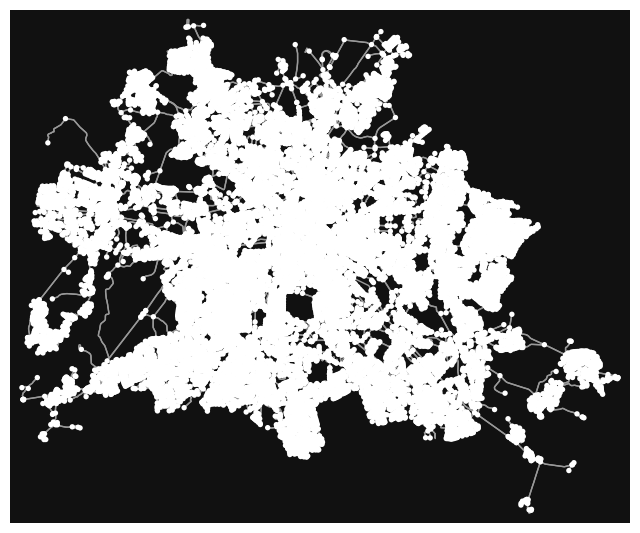

In [35]:
fig, ax = ox.plot_graph(G)

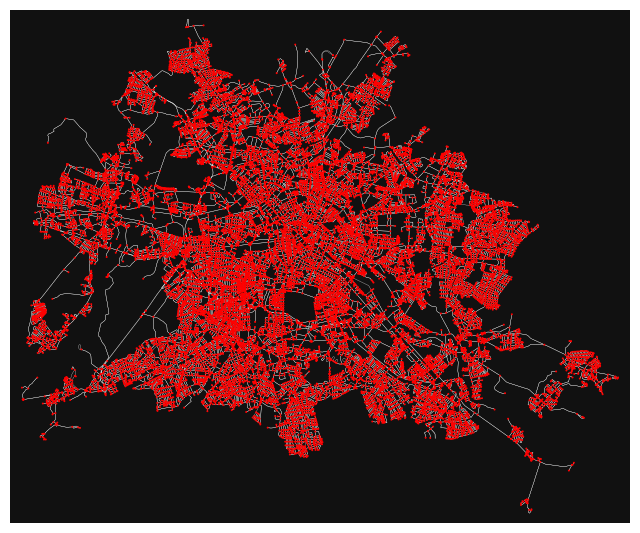

In [36]:
fig, ax = ox.plot_graph(G, node_size=2, node_color='r', edge_color='w', edge_linewidth=0.2)

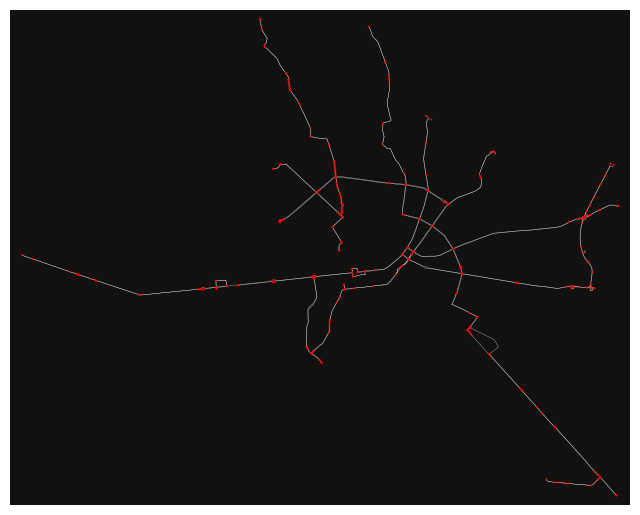

In [37]:
fig, ax = ox.plot_graph(G_p, node_size=2, node_color='r', edge_color='w', edge_linewidth=0.2)

In [38]:
nodes, edges = ox.utils_graph.graph_to_gdfs(G)
nodes.head()

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
172539,52.565209,13.335496,3,NaN,NaN,POINT (13.33550 52.56521)
172545,52.567033,13.346605,4,NaN,NaN,POINT (13.34661 52.56703)
172546,52.567681,13.352082,3,NaN,NaN,POINT (13.35208 52.56768)
172547,52.564079,13.339565,3,NaN,NaN,POINT (13.33956 52.56408)
172549,52.563396,13.342900,3,NaN,NaN,POINT (13.34290 52.56340)


In [39]:
edges[edges["highway"]=="primary"].head()

,,,osmid,lanes,name,highway,maxspeed,oneway,reversed,length,geometry,width,ref,bridge,tunnel,junction,access,area,service,est_width
u,v,key,,,,,,,,,,,,,,,,,,
172558,29688040,0,"[1132406755, 160130963]",2,Müllerstraße,primary,50,True,False,232.549,"LINESTRING (13.33738 52.55879, 13.33728 52.558...",10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172587,29493004,0,31910522,2,Lindauer Allee,primary,50,True,False,380.957,"LINESTRING (13.35211 52.57368, 13.35228 52.573...",NaN,B 96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172589,665285019,0,4594653,2,Residenzstraße,primary,30,True,False,197.620,"LINESTRING (13.35897 52.57325, 13.35906 52.573...",NaN,B 96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172594,21441701,0,4638313,2,Residenzstraße,primary,30,True,False,210.805,"LINESTRING (13.36081 52.57033, 13.36086 52.570...",NaN,B 96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530168,530176,0,"[35585207, 447883127, 485860823]","[3, 4, 5]",Kurt-Schumacher-Damm,primary,50,True,False,327.868,"LINESTRING (13.32186 52.56043, 13.32242 52.560...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
print(ox.graph_to_gdfs(G, nodes=False)['highway'].value_counts())

residential                                48388
secondary                                   8692
tertiary                                    7447
living_street                               3664
primary                                     2353
unclassified                                1107
motorway_link                                295
[residential, living_street]                 293
secondary_link                               287
motorway                                     167
primary_link                                 126
tertiary_link                                 63
[residential, unclassified]                   56
trunk                                         14
[residential, tertiary]                       10
road                                           8
[secondary, motorway_link]                     6
[primary_link, primary]                        5
trunk_link                                     4
[unclassified, living_street]                  4
[motorway, motorway_

In [41]:
import networkx as nx
from shapely.geometry import Polygon

In [42]:
total_length=0
for index, row in gdf_containment.iterrows():
    #print(row)
    nearest_node = ox.distance.nearest_nodes(G, row["x"], row["y"])
    #print(nearest_node)
    #nearest_highway_nodes = ox.distance.nearest_nodes(G, row.x, row.y, return_dist=False, method='balltree', infrastructure='highway')
    # Find the nearest nodes to the centroid
    nearest_nodes = ox.distance.nearest_nodes(G_p, row.x, row.y, return_dist=False)
    shortest_path = nx.shortest_path(G, source=nearest_node, target=nearest_nodes, weight='travel_time')
    #total_travel_time = sum(ox.utils_graph.get_route_edge_attributes(G, shortest_path, 'travel_time'))
    travel_time = nx.shortest_path_length(G, nearest_node, nearest_nodes, weight='travel_time')
    gdf_containment.loc[index,"travel_time_highway"]=travel_time

In [43]:
gdf_containment.head()

,osm_id_left,building,way_area_left,building_count_gap,way,amenity_count_500_atm,amenity_count_500_bicycle_parking,amenity_count_500_pharmacy,amenity_count_500_parking_entrance,amenity_count_500_charging_station,...,random,prediction,gap,name_right,index_right,osm_id_right,amenity,x,y,travel_time_highway
38,127058963,yes,491.838,1,"POLYGON ((1511384.348 6880446.353, 1511400.979...",0,24,0,0,0,...,1,2.596423,-3.403577,Berlin,NaN,NaN,NaN,1.511398e+06,6.880453e+06,45.0
68,712699469,yes,394.558,1,"POLYGON ((1489517.705 6902459.484, 1489536.662...",1,13,0,0,3,...,1,6.671132,-5.328868,Berlin,NaN,NaN,NaN,1.489531e+06,6.902465e+06,26.0
77,309824419,shed,131.221,2,"POLYGON ((1505045.237 6893272.587, 1505052.651...",0,15,2,1,0,...,1,5.518986,-1.481014,Berlin,NaN,NaN,NaN,1.505054e+06,6.893275e+06,45.0
85,749248606,apartments,341.976,2,"POLYGON ((1468892.262 6900231.085, 1468907.268...",0,0,0,1,1,...,1,2.750266,0.750266,Berlin,NaN,NaN,NaN,1.468904e+06,6.900237e+06,82.0
98,712306405,container,1953.550,4,"POLYGON ((1480807.633 6878521.570, 1480827.949...",0,6,0,2,0,...,1,1.234115,-0.765885,Berlin,NaN,NaN,NaN,1.480820e+06,6.878569e+06,52.0


In [45]:
gdf_containment.travel_time_highway.describe()

count    92933.000000
mean        46.400773
std         23.747193
min         10.000000
25%         26.000000
50%         44.000000
75%         64.000000
max        103.000000
Name: travel_time_highway, dtype: float64

In [48]:
gdf_containment

,osm_id_left,building,way_area_left,building_count_gap,way,amenity_count_500_atm,amenity_count_500_bicycle_parking,amenity_count_500_pharmacy,amenity_count_500_parking_entrance,amenity_count_500_charging_station,...,random,prediction,gap,name_right,index_right,osm_id_right,amenity,x,y,travel_time_highway
38,127058963,yes,491.838,1,"POLYGON ((1511384.348 6880446.353, 1511400.979...",0,24,0,0,0,...,1,2.596423,-3.403577,Berlin,NaN,NaN,NaN,1.511398e+06,6.880453e+06,45.0
68,712699469,yes,394.558,1,"POLYGON ((1489517.705 6902459.484, 1489536.662...",1,13,0,0,3,...,1,6.671132,-5.328868,Berlin,NaN,NaN,NaN,1.489531e+06,6.902465e+06,26.0
77,309824419,shed,131.221,2,"POLYGON ((1505045.237 6893272.587, 1505052.651...",0,15,2,1,0,...,1,5.518986,-1.481014,Berlin,NaN,NaN,NaN,1.505054e+06,6.893275e+06,45.0
85,749248606,apartments,341.976,2,"POLYGON ((1468892.262 6900231.085, 1468907.268...",0,0,0,1,1,...,1,2.750266,0.750266,Berlin,NaN,NaN,NaN,1.468904e+06,6.900237e+06,82.0
98,712306405,container,1953.550,4,"POLYGON ((1480807.633 6878521.570, 1480827.949...",0,6,0,2,0,...,1,1.234115,-0.765885,Berlin,NaN,NaN,NaN,1.480820e+06,6.878569e+06,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2848583,48504497,yes,400.145,1,"POLYGON ((1478112.778 6908141.287, 1478122.307...",0,23,0,2,0,...,1,2.009087,2.009087,Berlin,NaN,NaN,NaN,1.478125e+06,6.908133e+06,59.0
2848604,372016273,yes,156.096,1,"POLYGON ((1502096.596 6875026.748, 1502104.900...",0,1,0,1,0,...,1,0.681357,0.681357,Berlin,NaN,NaN,NaN,1.502104e+06,6.875033e+06,28.0
2848674,693609833,yes,116.796,1,"POLYGON ((1503561.393 6902034.615, 1503569.942...",0,21,0,2,0,...,1,1.263553,-0.736447,Berlin,NaN,NaN,NaN,1.503567e+06,6.902040e+06,52.0
2848689,289150547,yes,100.149,2,"POLYGON ((1494271.615 6900801.831, 1494272.917...",0,28,0,4,1,...,1,5.908641,1.908641,Berlin,NaN,NaN,NaN,1.494278e+06,6.900797e+06,64.0


In [49]:
gdf_containment.loc[38,'x']

1511398.4515941744

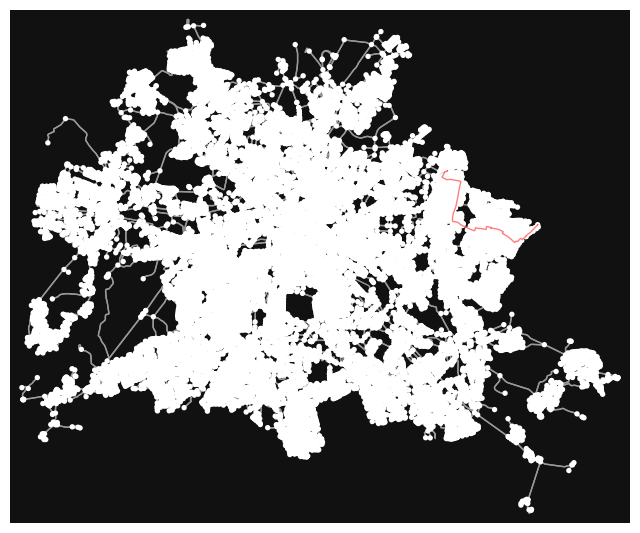

In [51]:
fig, ax = ox.plot_graph_route(G, shortest_path,route_linewidth=1,orig_dest_size=1)

# Create a polygon (example coordinates, replace with your own)
#polygon_coords = [gdf.centroid[1443790]]
#polygon = Polygon(polygon_coords)
#polygon_gdf = gpd.GeoDataFrame(geometry=[polygon])
#polygon_gdf.plot(ax=ax, facecolor='yellow', edgecolor='yellow',)
point_coords = (gdf_containment.loc[38,'x'],gdf_containment.loc[38,'y'])
#point = Point(gdf.centroid[1443790].x,gdf.centroid[1443790].y,)
ax.scatter(point_coords[0], point_coords[1], color='red', label='Point',s=100000,marker='o',alpha=1,  zorder=5)
# Show the plot
plt.show()

In [52]:
gdf_containment_model=gdf_containment.drop(columns=["osm_id_left","building","way","random","name_right","index_right","osm_id_right","way_area_right","name_left","name_left"])

In [53]:
gdf_containment_model.head()

,way_area_left,building_count_gap,amenity_count_500_atm,amenity_count_500_bicycle_parking,amenity_count_500_pharmacy,amenity_count_500_parking_entrance,amenity_count_500_charging_station,amenity_count_500_taxi,amenity_count_500_bank,amenity_count_500_post_office,...,amenity_count_1000_pharmacy,amenity_count_1000_bank,amenity_count_1000_bicycle_parking,food_and_bev,prediction,gap,amenity,x,y,travel_time_highway
38,491.838,1,0,24,0,0,0,0,0,0,...,2,0,61,6,2.596423,-3.403577,NaN,1.511398e+06,6.880453e+06,45.0
68,394.558,1,1,13,0,0,3,0,0,0,...,1,0,84,12,6.671132,-5.328868,NaN,1.489531e+06,6.902465e+06,26.0
77,131.221,2,0,15,2,1,0,1,0,1,...,2,0,65,7,5.518986,-1.481014,NaN,1.505054e+06,6.893275e+06,45.0
85,341.976,2,0,0,0,1,1,0,0,0,...,2,1,0,2,2.750266,0.750266,NaN,1.468904e+06,6.900237e+06,82.0
98,1953.550,4,0,6,0,2,0,0,0,0,...,1,0,9,2,1.234115,-0.765885,NaN,1.480820e+06,6.878569e+06,52.0


In [54]:
gdf_containment_model.amenity.value_counts()

restaurant    1992
cafe          1096
fast_food      923
pub            427
bar            394
ice_cream      140
Name: amenity, dtype: int64

In [56]:
gdf_containment_model['amenity_bin'] = gdf_containment_model['amenity'].notna().astype(int)

In [57]:
gdf_containment_model[gdf_containment_model["amenity_bin"]==1]

,way_area_left,building_count_gap,amenity_count_500_atm,amenity_count_500_bicycle_parking,amenity_count_500_pharmacy,amenity_count_500_parking_entrance,amenity_count_500_charging_station,amenity_count_500_taxi,amenity_count_500_bank,amenity_count_500_post_office,...,amenity_count_1000_bank,amenity_count_1000_bicycle_parking,food_and_bev,prediction,gap,amenity,x,y,travel_time_highway,amenity_bin
431,572.469,1,7,45,2,4,2,1,1,0,...,1,154,82,78.975958,-3.024042,cafe,1.491790e+06,6.895341e+06,26.0,1
884,527.622,1,9,36,2,0,1,1,1,0,...,1,147,95,91.386469,-3.613531,bar,1.491706e+06,6.896768e+06,26.0,1
2028,1359.290,3,1,6,5,0,0,1,3,0,...,4,11,18,19.723480,1.723480,restaurant,1.476993e+06,6.892930e+06,45.0,1
5169,579.324,1,5,47,1,2,2,1,0,0,...,1,85,73,52.520760,-20.479240,restaurant,1.491126e+06,6.888996e+06,76.0,1
8900,552.538,1,10,5,3,2,5,1,0,0,...,4,36,51,46.966850,-4.033150,restaurant,1.483634e+06,6.884905e+06,26.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2839069,18164.300,4,4,11,4,4,1,1,3,1,...,3,24,4,11.925651,7.925651,fast_food,1.502279e+06,6.915706e+06,24.0,1
2842403,2107.560,1,6,29,1,5,3,1,1,1,...,1,122,66,50.344156,-15.655844,restaurant,1.490392e+06,6.896382e+06,70.0,1
2842403,2107.560,1,6,29,1,5,3,1,1,1,...,1,122,66,50.344156,-15.655844,cafe,1.490392e+06,6.896382e+06,70.0,1
2845167,3092.140,2,10,76,5,4,2,1,4,1,...,5,243,73,68.141894,-4.858106,fast_food,1.493207e+06,6.900086e+06,57.0,1


In [58]:
gdf_containment_model=gdf_containment_model.drop(columns="amenity")

In [ ]:
gdf_containment_model

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier

In [60]:
X_train, X_test, y_train, y_test = train_test_split(gdf_containment_model.drop(columns=["amenity_bin","centroid"]), gdf_containment_model["amenity_bin"], test_size = 0.3, random_state = 101)

In [61]:
xgbr = XGBClassifier(n_estimators = 100, max_depth = 5, random_state = 114)
xgbr.fit(X_train, y_train)

predictions = xgbr.predict(X_test)

In [62]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.9534791965566715

In [63]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     26412
           1       0.68      0.22      0.33      1468

    accuracy                           0.95     27880
   macro avg       0.82      0.61      0.65     27880
weighted avg       0.94      0.95      0.94     27880



*As there is a clearly imbalanced in the classes that reflects in the results for predicting the class 1, we will apply oversampling*

In [64]:
import imblearn
from imblearn.over_sampling import SMOTE 

In [65]:
X, y = gdf_containment_model.drop(columns=["amenity_bin","centroid"]), gdf_containment_model["amenity_bin"]

In [66]:
gdf_containment_model.shape

(92933, 96)

In [67]:
oversample = SMOTE()
oversample = SMOTE(random_state = 2)
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

In [68]:
sum(y == 0)

87961

In [111]:
xgbr = XGBClassifier(n_estimators = 100, max_depth = 20, random_state = 114)
xgbr.fit(X_train_os, y_train_os)

predictions = xgbr.predict(X_test)

In [112]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.9506814921090387

In [113]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     26412
           1       0.54      0.44      0.49      1468

    accuracy                           0.95     27880
   macro avg       0.75      0.71      0.73     27880
weighted avg       0.95      0.95      0.95     27880



In [114]:
import shap

In [117]:
X_train_os.shape

(123098, 94)

In [115]:
explainer = shap.Explainer(xgbr, X_train_os.sample(10000,random_state=111))
shap_values = explainer(X_train_os.sample(10000,random_state=111))

[22:55:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[22:55:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 9985/10000 [03:22<00:00]        

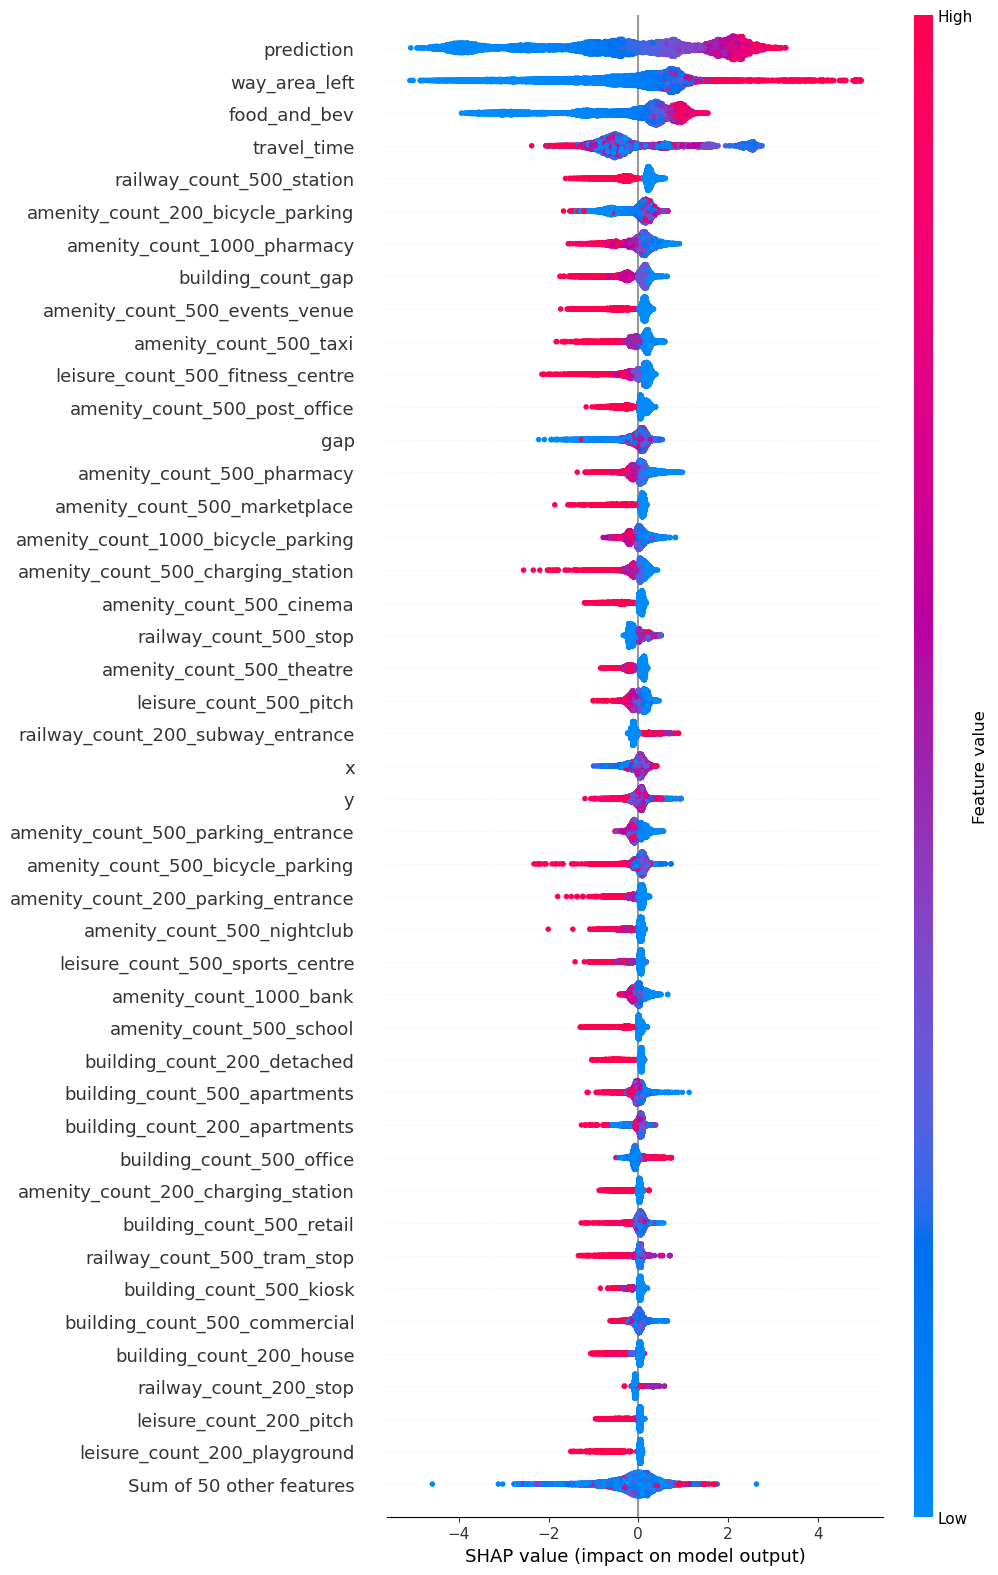

In [215]:
shap.plots.beeswarm(shap_values, max_display=45)